# Financial Volatility Forecasting with GARCH

**Aman's portfolio showcase** — a polished Jupyter Notebook demonstrating a full workflow: data loading from SQLite, EDA, GARCH modeling, evaluation, and deployment notes.

This notebook uses the provided `stocks.sqlite` dataset. It is designed to be easy to run and to highlight quantitative skills relevant to algorithmic trading and volatility modeling.


## Setup

If you don't have the required packages installed, run the cell below. It installs commonly used packages for time series analysis and GARCH modeling.

_Run the install cell only if needed._

In [ ]:
# Uncomment the following pip installs if you need to install dependencies in your environment.
# Note: In many managed environments these packages are already available.
#!pip install pandas matplotlib statsmodels arch jupyterlab seaborn
print("If you need packages, uncomment and run the pip install line in this cell.")


  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached jupyterlab-4.4.10-py3-none-any.whl.metadata (16 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.3.4-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using ca

## Imports and helper functions

In [4]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from datetime import datetime
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12,6)

def load_from_sqlite(db_path, table_name=None):
    conn = sqlite3.connect(db_path)
    # if table_name is None, list tables and pick a sensible one
    if table_name is None:
        tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table'""", conn)
        if len(tables) == 0:
            raise ValueError('No tables in sqlite file.')
        table_name = tables['name'].iloc[0]
        print(f"No table specified. Using first table: {table_name}")
    df = pd.read_sql(f"SELECT * FROM '{table_name}'", conn)
    conn.close()
    return df


## Load data from provided SQLite database

We'll load the dataset inside `stocks.sqlite`. If multiple tables exist we'll automatically use the first one.

In [6]:
# Path to the provided SQLite file (already in the workspace)
sqlite_path = r"stocks.sqlite"
print('SQLite path exists:', os.path.exists(sqlite_path))

# Load
df = load_from_sqlite(sqlite_path)
print('Loaded dataframe shape:', df.shape)
df.head()


SQLite path exists: True
No table specified. Using first table: MTNOY
Loaded dataframe shape: (4498, 6)


,date,open,high,low,close,volume
0,2025-05-28 00:00:00,7.004,7.04,6.910,6.975,5839.0
1,2025-05-27 00:00:00,7.040,7.04,6.682,6.790,7725.0
2,2025-05-23 00:00:00,6.790,6.89,6.780,6.890,3518.0
3,2025-05-22 00:00:00,6.650,6.73,6.650,6.685,9198.0
4,2025-05-21 00:00:00,6.780,6.82,6.650,6.780,6512.0


## Data preparation

Convert date/time columns to datetime, sort by time, and compute log returns.

In [7]:
# Common column names we might expect
possible_datetime_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'datetime' in c.lower()]
print('Possible datetime columns:', possible_datetime_cols)

# Heuristic: find a column with 'date' or 'datetime' or combine date+time
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
elif 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
elif 'date' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'])
else:
    # try to infer index if it looks like an index
    try:
        df['datetime'] = pd.to_datetime(df.iloc[:,0])
        print('Used first column as datetime.')
    except Exception as e:
        print('Could not infer datetime automatically — please inspect the dataframe and set df["datetime"] manually. Error:', e)

# Identify price column to use for returns
price_cols = [c for c in df.columns if c.lower() in ['close','adjclose','adj_close','close_price','price']]
if not price_cols:
    # try some heuristics
    price_cols = [c for c in df.columns if 'close' in c.lower() or 'price' in c.lower()]
print('Price columns detected:', price_cols)

price_col = price_cols[0] if len(price_cols)>0 else None
if price_col is None:
    raise ValueError('No price column detected. Please rename your price column to "close" or similar.')

# Prepare time series
ts = df[[ 'datetime', price_col]].copy()
ts = ts.dropna().sort_values('datetime').set_index('datetime')
ts.index = pd.to_datetime(ts.index)
ts = ts[~ts.index.duplicated(keep='first')]
ts.head()


Possible datetime columns: ['date']
Price columns detected: ['close']


,close
datetime,
2007-07-13,14.80
2007-07-16,14.95
2007-07-17,14.58
2007-07-18,14.70
2007-07-19,15.05


## Exploratory Data Analysis (EDA)

Plot price series and returns, and inspect volatility clustering.

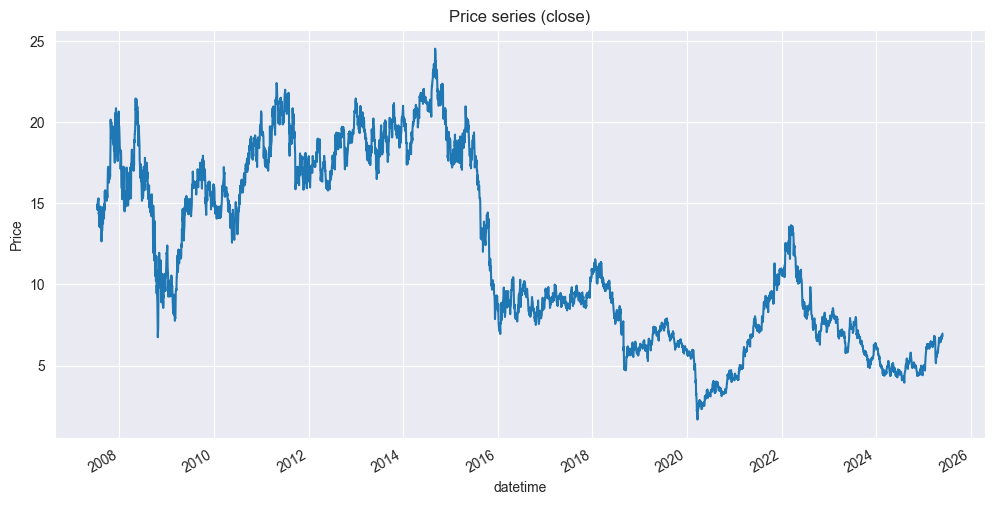

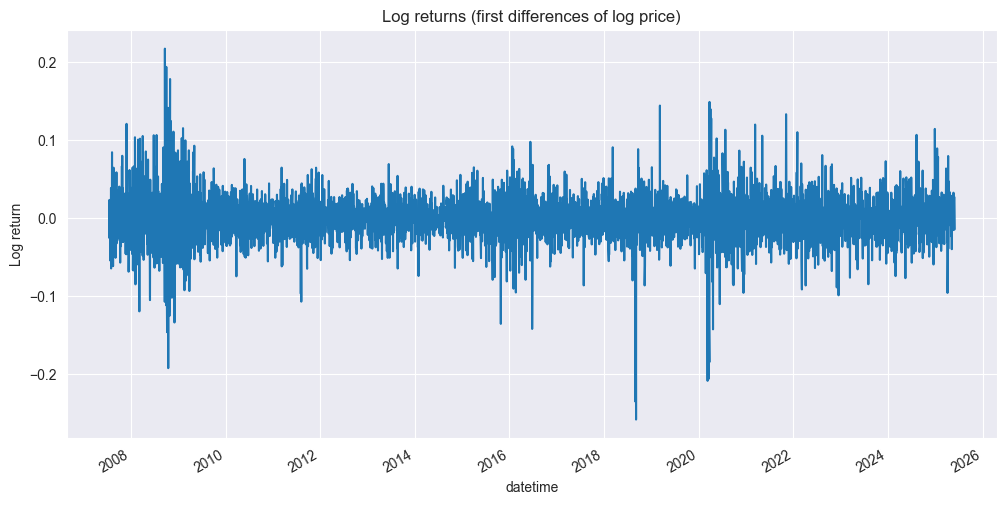

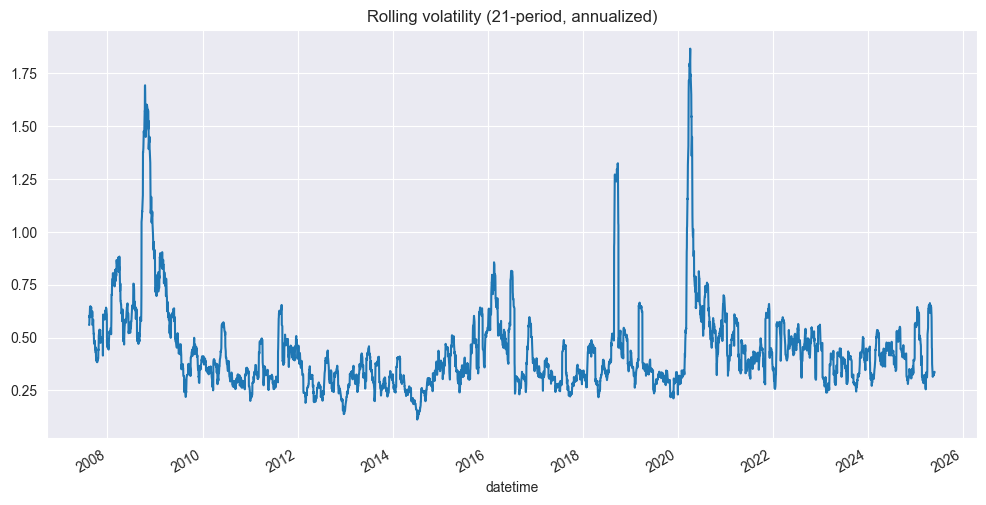

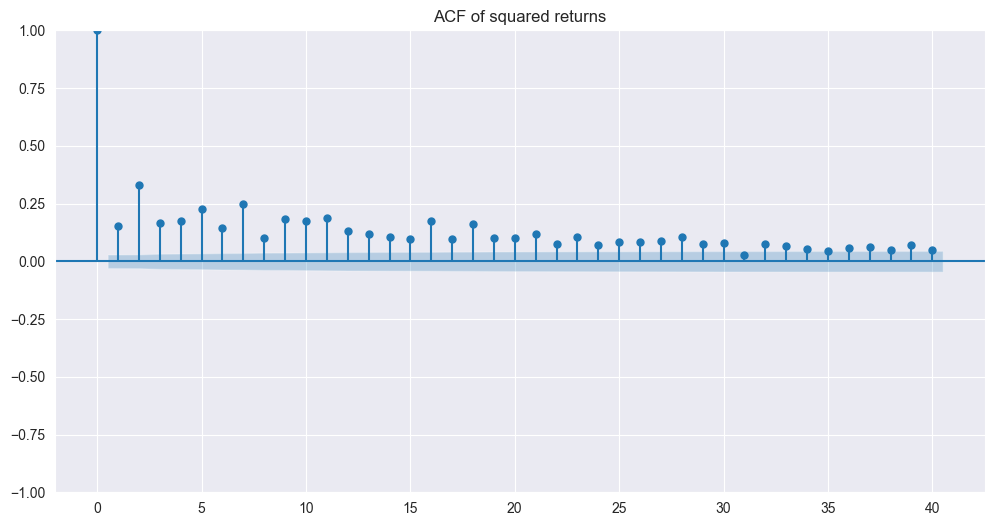

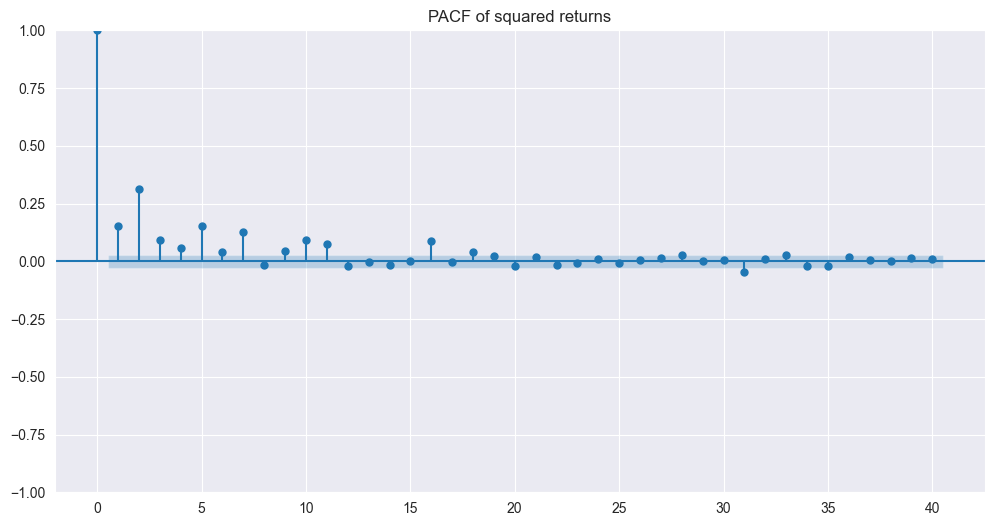

In [8]:
# Price plot
ts.plot(title=f'Price series ({price_col})', legend=False)
plt.ylabel('Price')
plt.show()

# Compute log returns
ts['log_ret'] = np.log(ts[price_col]).diff().dropna()
rets = ts['log_ret'].dropna()

rets.plot(title='Log returns (first differences of log price)')
plt.ylabel('Log return')
plt.show()

# Rolling volatility
rolling_vol = rets.rolling(window=21).std() * np.sqrt(252)  # annualized (if daily)
rolling_vol.plot(title='Rolling volatility (21-period, annualized)')
plt.show()

# ACF/PACF of squared returns to show ARCH effects
plot_acf(rets.dropna()**2, lags=40, title='ACF of squared returns')
plt.show()
plot_pacf(rets.dropna()**2, lags=40, title='PACF of squared returns')
plt.show()


## GARCH(1,1) model fitting

Fit a GARCH(1,1) model to log returns and extract volatility forecasts.

In [9]:
# Fit GARCH(1,1)
am = arch_model(rets*100, vol='Garch', p=1, q=1, dist='normal')  # scale returns for numerical stability
res = am.fit(update_freq=10, disp='off')
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10858.8
Distribution:                  Normal   AIC:                           21725.5
Method:            Maximum Likelihood   BIC:                           21751.2
                                        No. Observations:                 4497
Date:                Sat, Nov 01 2025   Df Residuals:                     4496
Time:                        13:49:43   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.7264e-03  3.727e-02  7.314e-02      0.942 

## Forecast volatility and plot

We produce an out-of-sample forecast and plot predicted volatility vs realized (squared returns).

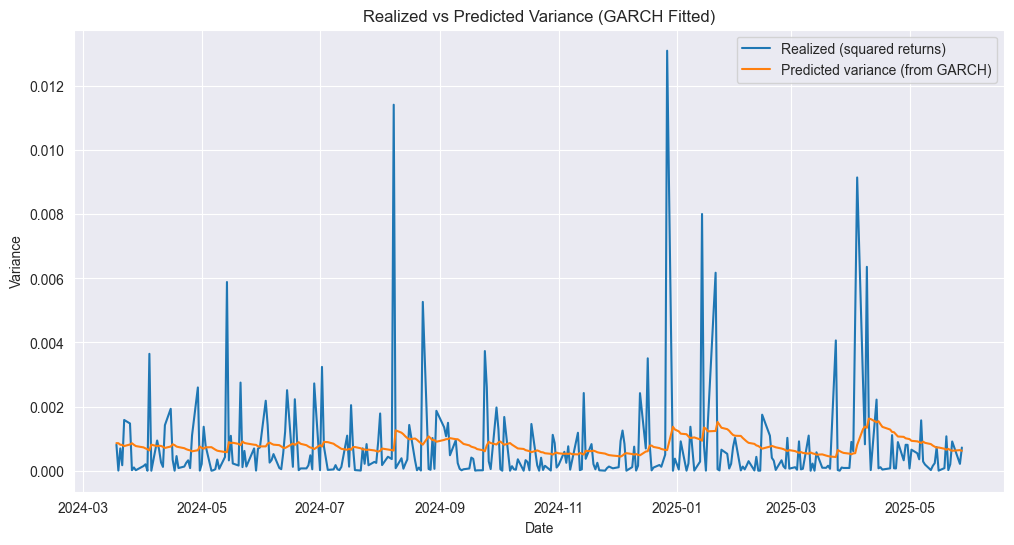

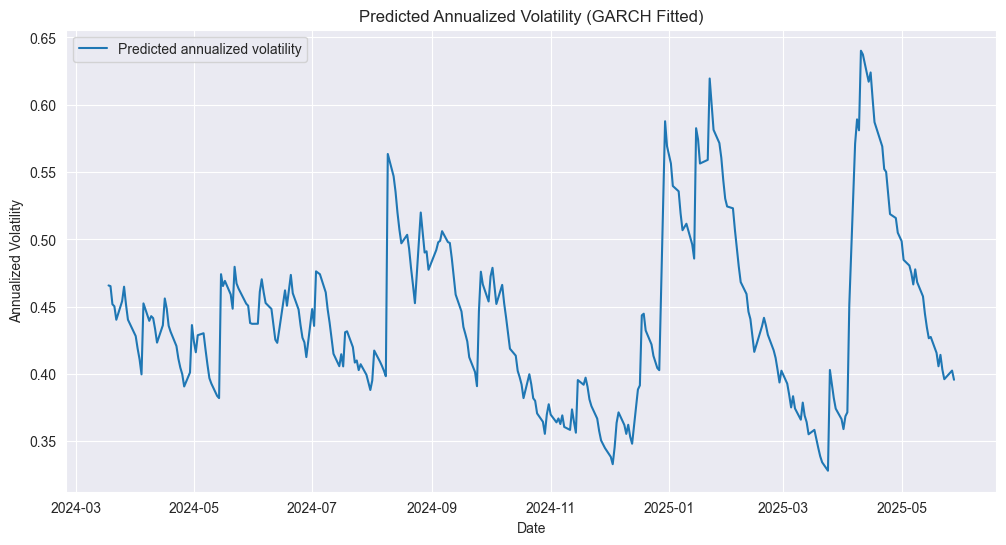

Next 5-day forecasted volatility:
Day +1: 0.0251
Day +2: 0.0252
Day +3: 0.0252
Day +4: 0.0253
Day +5: 0.0254


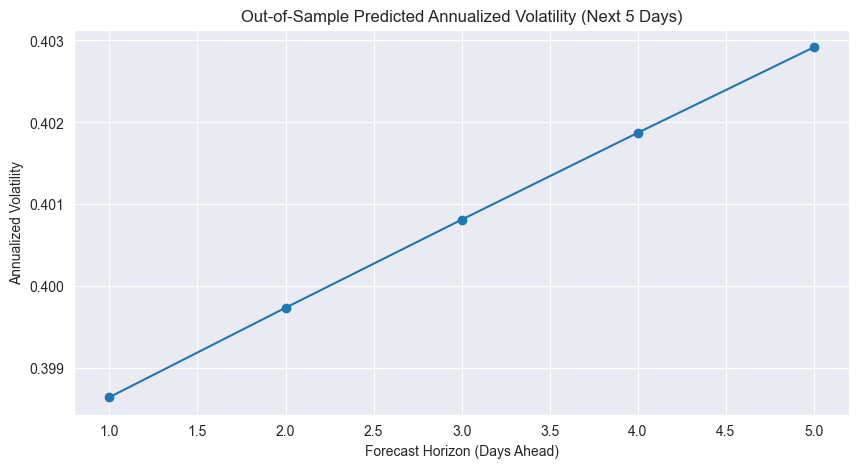

In [17]:


# The model was fit on returns * 100, so we divide by 100 to rescale back
fitted_vol = res.conditional_volatility / 100.0  

# Align volatility with returns
pred_vol_series = pd.Series(fitted_vol, index=rets.index, name='pred_vol')

# Plot realized (squared returns) vs predicted variance
plt.figure(figsize=(12,6))
plt.plot(rets[-300:]**2, label='Realized (squared returns)')
plt.plot(pred_vol_series[-300:]**2, label='Predicted variance (from GARCH)')
plt.legend()
plt.title('Realized vs Predicted Variance (GARCH Fitted)')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.show()

# Plot predicted annualized volatility (in-sample)
plt.figure(figsize=(12,6))
plt.plot(pred_vol_series[-300:] * np.sqrt(252), label='Predicted annualized volatility')
plt.legend()
plt.title('Predicted Annualized Volatility (GARCH Fitted)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()


# 2️⃣ Out-of-sample volatility forecast (e.g., next 5 days)
# ---------------------------------------------------------
forecast_horizon = 5
forecasts = res.forecast(horizon=forecast_horizon, reindex=False)

# Extract the last forecasted variances and convert to volatility
future_vol = np.sqrt(forecasts.variance.values[-1, :]) / 100.0

# Display forecasted volatilities
print("Next 5-day forecasted volatility:")
for i, vol in enumerate(future_vol, start=1):
    print(f"Day +{i}: {vol:.4f}")

# Optional: Plot the forecasted volatility curve
plt.figure(figsize=(10,5))
plt.plot(range(1, forecast_horizon+1), future_vol * np.sqrt(252), marker='o')
plt.title('Out-of-Sample Predicted Annualized Volatility (Next 5 Days)')
plt.xlabel('Forecast Horizon (Days Ahead)')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()


In [15]:
pred_vol_series

datetime
2025-05-28    0.025112
Name: pred_vol, dtype: float64

## Model diagnostics

Analyze standardized residuals and check for remaining ARCH effects.

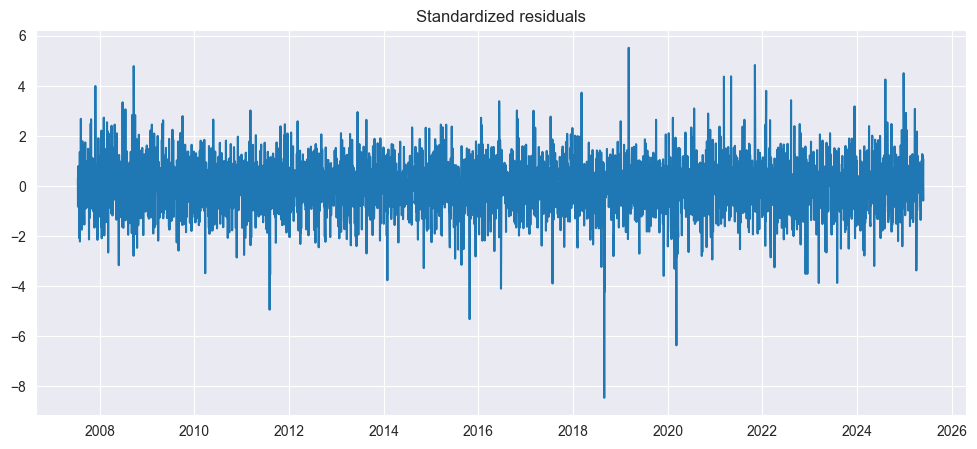

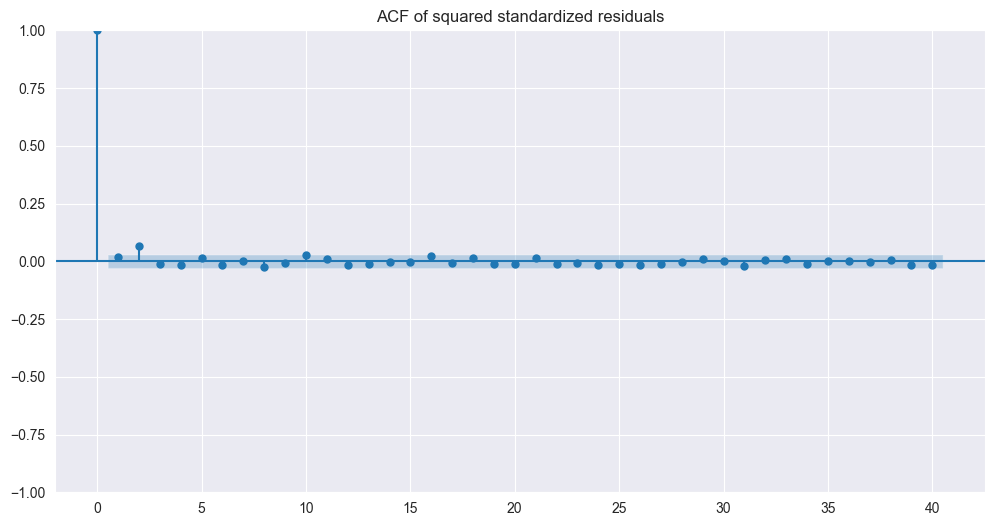

In [11]:
std_resid = res.std_resid.dropna()
plt.figure(figsize=(12,5))
plt.plot(std_resid)
plt.title('Standardized residuals')
plt.show()

# ACF of squared standardized residuals
plot_acf(std_resid**2, lags=40, title='ACF of squared standardized residuals')
plt.show()


## Deployment notes

- The model can be wrapped into a script (src/) and scheduled to run daily to provide volatility forecasts used for options pricing or risk sizing.
- Save the fitted model parameters and load them for fast inference.

## Conclusion

This notebook showed a full workflow: loading historical price data from a local SQLite file, EDA, fitting a GARCH(1,1) model, producing volatility forecasts, and brief diagnostics.

---

**Author:** Aman — Algorithmic Trader | Quantitative Research


## Appendix: Environment & Requirements

The `requirements.txt` included with this project contains the necessary Python packages. Run the notebook in a Python 3.9+ environment. For reproducibility consider using a virtual environment or conda environment.